In [1]:
from ml.models.layers import MyTransformerBlock, MyAddPositionEmbs, MyClassToken
import os
import datetime
from pathlib import Path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.callbacks import TensorBoard
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import Adam

from cfg import LOG_DIR
from ml.models.MySimpleCNN_Feit import MySimpleCNNInceptionModule

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipelineEncoderDecoder
import tensorflow
from tensorflow import keras

tensorflow.compat.v1.disable_eager_execution()

from keras_preprocessing.image import ImageDataGenerator

name = 'MySimpleCNN_Autoencoder_ViT-pos-emb-v4'

class MyAutoencoder(FeitDataPipelineEncoderDecoder):

    def _train_model(self, data_train, data_valid):
        raise NotImplementedError("This method is intentionally not implemented in this instance")

    def __init__(self, *args, **kwargs):

        self.params.tile_size=128
        super().__init__(*args, **kwargs)

        self.params.latent_representation_size = 8*8
        self.params.tile_size=128
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.model = MyAutoencoder.get_model(self.params.latent_representation_size)
        self.params.neighborhood_tiles = 2


    def get_optimizer(self):
        lr_schedule = schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=100,
            decay_rate=0.1,
            staircase= True)

        return Adam(
            # learning_rate=0.1,
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999)

    @staticmethod
    def get_encoder(encoder_vector_length: int):

        inputs = keras.Input(shape=(128, 128, 3))

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                                          filters_1=8,
                                                                          filters_2=8)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=8,
                                                                          filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=16,
                                                                          filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=16,
                                                                          filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=32,
                                                                          filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)

        encoder = tensorflow.keras.layers.Flatten()(x)
        encoder = tensorflow.keras.layers.Dense(encoder_vector_length)(encoder)

        encoder_model = tensorflow.keras.Model(inputs, encoder)

        return encoder_model, inputs

    @staticmethod
    def get_decoder(encoder_vector_length: int):
        decoder_input = tensorflow.keras.layers.Input(shape=(encoder_vector_length,))

        decoder = tensorflow.keras.layers.Dense(8 * 8, activation="relu")(decoder_input)
        decoder = tensorflow.keras.layers.Reshape((8, 8, 1))(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(3, 1, activation="sigmoid", strides=1, padding="same")(decoder)

        decoder_model = tensorflow.keras.Model(decoder_input, decoder)

        return decoder_model


    @staticmethod
    def get_model(encoder_vector_length: int):
        encoder_model, input_data = MyAutoencoder.get_encoder(encoder_vector_length)

        decoder_model = MyAutoencoder.get_decoder(encoder_vector_length)

        encoded = encoder_model(input_data)
        decoded = decoder_model(encoded)

        autoencoder = tensorflow.keras.models.Model(input_data, decoded)

        autoencoder.compile(loss='mean_squared_error', optimizer='adam')

        return autoencoder

    def get_combinator_model(self):

        inputs = [keras.Input(shape=(self.params.latent_representation_size, )) for i in range((self.params.neighborhood_tiles * 2 + 1) ** 2)]

        reshaped = [keras.layers.Reshape((1, 64))(_input) for _input in inputs]
        x = keras.layers.Concatenate(axis=1)(reshaped)

        x = MyClassToken(name="class_token")(x)
        x = MyAddPositionEmbs(name="Transformer/posembed_input")(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x = keras.layers.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(x)
        x = keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(x)
        x = keras.layers.Dense(512, name="pre_logits", activation="tanh")(x)

        output = keras.layers.Dense(units = 11, activation = 'softmax')(x)

        neighborhood_model = keras.Model(inputs=inputs, outputs=output)
        return neighborhood_model

    def _train_model_ae_neighborhood(self, data_train_autoencoder, data_valid_autoencoder,
                                            data_train_classifier, data_valid_classifier,
                                           data_train_neighborhood, data_valid_neighborhood):

        autoencoder = MyAutoencoder.get_model(encoder_vector_length=8*8)
        autoencoder.fit(data_train_autoencoder, epochs=100, steps_per_epoch=100, validation_data=data_valid_autoencoder,
                        validation_steps=self.params.batch_size * 5, validation_freq=10)


        # MyAutoencoder.autoencoder_showcase(data_train_autoencoder, autoencoder)

        inputs = autoencoder.input
        outputs = autoencoder.layers[1].output

        encoder_model = keras.Model(inputs, outputs, name=(self.params.name + '_encoder'))

        neighborhood_networks = [MyAutoencoder._get_basic_layers(keras.models.clone_model(encoder_model), model_idx)
                                 for model_idx in range((self.params.neighborhood_tiles * 2 + 1) ** 2)]
        encoders_outputs = [model[1] for model in neighborhood_networks]
        encoders_inputs = [model[0] for model in neighborhood_networks]

        parallel_encoder_model = keras.Model(inputs=encoders_inputs, outputs=encoders_outputs)

        neighbourhood_model = self.get_combinator_model()
        output_probs = neighbourhood_model(encoders_outputs)

        neighborhood_autoencoder_model = keras.Model(inputs=parallel_encoder_model.inputs, outputs=output_probs)
        neighborhood_autoencoder_model.compile(loss='binary_crossentropy', optimizer='adam',
                                               metrics=[keras.metrics.CategoricalAccuracy()])


        tensorboard = TensorBoard(log_dir=LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        neighborhood_autoencoder_model.fit(data_train_neighborhood,
                       steps_per_epoch=250,
                       epochs=100,
                       shuffle=True,
                       validation_data=data_valid_neighborhood, validation_steps=100,
                       validation_freq=5,
                       verbose=1,
                       callbacks=[tensorboard, PlotLossesKerasTF()])

        self.model = neighborhood_autoencoder_model
        self.model.summary()
        self.model_encoder = encoder_model
        self.model_combinator = keras.Model(inputs = self.model.layers[-1].input, outputs = self.model.layers[-1].output)

/home/jelinek/recetox/src/notebooks


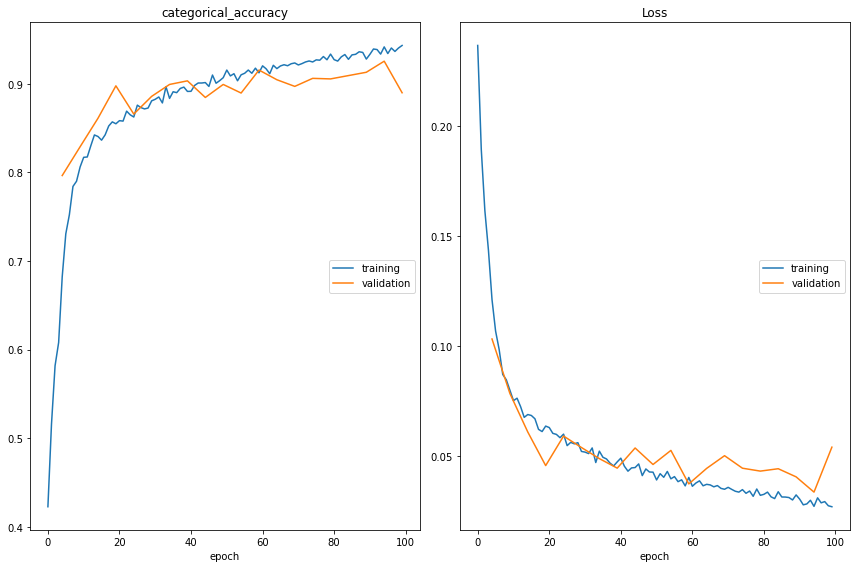

categorical_accuracy
	training         	 (min:    0.423, max:    0.943, cur:    0.943)
	validation       	 (min:    0.797, max:    0.926, cur:    0.890)
Loss
	training         	 (min:    0.027, max:    0.237, cur:    0.027)
	validation       	 (min:    0.034, max:    0.103, cur:    0.054)
250/250 [==============================] - 185s 742ms/step - batch: 124.5000 - size: 32.0000 - loss: 0.0271 - categorical_accuracy: 0.9434 - val_loss: 0.0542 - val_categorical_accuracy: 0.8900


In [2]:
pipeline = MyAutoencoder(
                         data_train_autoencoder='data/Feit_colon-annotation-tiles-128/data_train/',
                         data_valid_autoencoder='data/Feit_colon-annotation-tiles-128/data_valid/',
                         data_train_neighborhood='data/Feit_colon-annotation-tiles-128-2-neighbourhood/data_train',
                         data_valid_neighborhood='data/Feit_colon-annotation-tiles-128-2-neighbourhood/data_valid',
                         train_data_dir='data/Feit_colon-annotation-tiles-128/data_train/',
                         valid_data_dir='data/Feit_colon-annotation-tiles-128/data_valid/')

pipeline.execute_pipeline(perform_validation=False, perform_test_segmentation=False)

In [3]:
pipeline.save_pipeline()

In [5]:
pipeline = FeitDataPipelineEncoderDecoder.load_pipeline(pipeline_name=name)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from ml.eval import eval_model

eval_model(pipeline.model,
           pipeline.get_data_loader_validation_neighborhood(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

Measuring time
--Iteration 10/10
Batch size: 32
Mean time per tile 3.4794ms
Confusion Matrix
[[ 723    3   14    0    0    0    2    0    0    0  146]
 [   5  142   41    0    3    0   16    2    0    0    5]
 [   5   15  337    0    6    0   17    5    0    0    5]
 [   0    0    0   22    1    0    0    0    0    0    0]
 [   0    3   13    0 1279    0    0    0    0    0    0]
 [   0    0    0    0    0    2    0    0    0    0    1]
 [   0    6   17    0    0    0  163    4    0    0    0]
 [   0    1    4    0    0    0   12  181    0    0    0]
 [   1    1    0    0    0    0    0    0    0    0    0]
 [   0    0    2    0    0    0    0    0    0    0    1]
 [  30    0    1    0    0    0    0    0    0    0  475]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.95      0.81      0.88       888
          blood_and_vessels       0.83      0.66      0.74       214
          connective_tissue       0.79

In [6]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/ns-adenoca-colon-15071-2019-20x-he-4/')
# evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=pipeline.params.neighborhood_tiles, combinator_model=pipeline.model_combinator,
                                         combination_procedure='neural_networks')

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Processing region 437 out of 437
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 927.241527557373 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Autoencoder_ViT-pos-emb-v4/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Aggregated evaluation: 
[[18262     0     0     0 16642     0     0     0     0     0  5130]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [ 1823     0     0     0   639     0     0     0     0     0  9839]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [89142     0     0     0   140     0     0     0     0     0  4245]
 [  242     0     0     0   403     0     0     0     0     0  1182]
 [  217     0     0     0    59     0     0     0     0     0  4183]
 [  967     0     0     0  1111     0     0     0     0     0 16324]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     